In [2]:
from typing import cast
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# retrieve input datsets
wordlist = set(pd.read_csv("input_data/words.csv", encoding="UTF-8")["words"])
mails = pd.read_csv("input_data/enron_spam_data.csv")
mails.drop(labels=["Message ID", "Date", "Subject"], axis=1, inplace=True)
mails.dropna(subset=["Message"], inplace=True)
mails.rename(
    columns={"Message": "message", "Spam/Ham": "spam"},
    inplace=True,
)
mails["spam"] = mails["spam"].map(
    lambda spam_ham: True if spam_ham == "spam" else False
)

mails_split = train_test_split(mails, test_size=0.2, random_state=123, shuffle=True)
train_data, test_data = cast(tuple[pd.DataFrame, pd.DataFrame], mails_split)
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

# download nltk datsets
nltk.download("stopwords")
nltk.download("punkt_tab")
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lateridiot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lateridiot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Implement Naive Bayes using CountVectorizer + scikit-learn
def clean_message(text: str) -> list[str]:
    """Lower-case, tokenize, stem and filter tokens."""
    text = text.lower()
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in tokens if w.isalpha() and w not in stop_words and w in wordlist]

# Vectorize using our tokenizer so the same cleaning/filtering is applied
vectorizer = CountVectorizer(tokenizer=clean_message, lowercase=True, stop_words=list(stop_words))
X_train = vectorizer.fit_transform(train_data["message"])
X_test = vectorizer.transform(test_data["message"])
y_train = train_data["spam"]
y_test = test_data["spam"]

/home/lateridiot/IT-371/Project/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/lateridiot/IT-371/Project/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'would'] not in stop_words.
  warnings.warn(


In [5]:
# Train Multinomial Naive Bayes
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

# Predict & evaluate
predictions = clf.predict(X_test)

In [6]:
# Precision, recall, F1 (scikit-learn classification_report)
print(classification_report(y_test, predictions, target_names=["Ham", "Spam"], digits=4))

              precision    recall  f1-score   support

         Ham     0.9433    0.9568    0.9500      3197
        Spam     0.9597    0.9470    0.9533      3472

    accuracy                         0.9517      6669
   macro avg     0.9515    0.9519    0.9517      6669
weighted avg     0.9518    0.9517    0.9517      6669



True Positive: 3288
False Negative: 184
True Negative: 3059
False Positive: 138


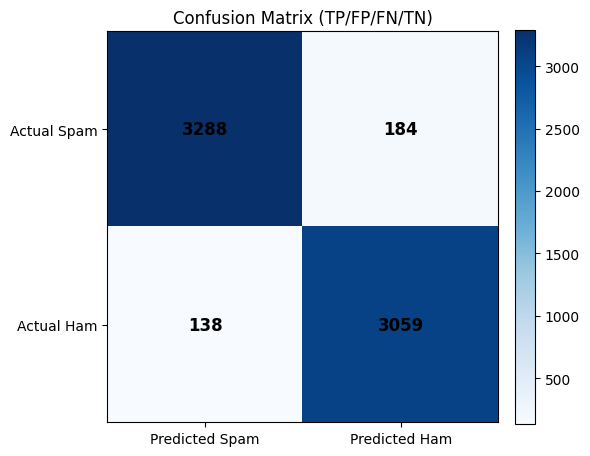

In [7]:
# Confusion matrix + TP/TN/FP/FN chart
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[False, True]).ravel()

print(f"True Positive: {tp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")

fig, ax = plt.subplots(figsize=(6, 6))
matrix = [[tp, fn], [fp, tn]]
im = ax.imshow(matrix, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Predicted Spam", "Predicted Ham"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Actual Spam", "Actual Ham"])

for (i, j), value in [((0, 0), tp), ((0, 1), fn), ((1, 0), fp), ((1, 1), tn)]:
    ax.text(j, i, f"{value}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

ax.set_title("Confusion Matrix (TP/FP/FN/TN)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [19]:
def predict_example(example_message: str) -> None:
    """Predict if example message is spam or ham."""
    clean_example = clean_message(example_message)
    example_vector = vectorizer.transform([example_message])
    proba_spam = clf.predict_proba(example_vector)[0][1]
    prediction = proba_spam >= 0.5
    pred_label = "Spam" if prediction else "Ham"

    print(f"Message: {example_message.strip()}")
    print(f"Cleaned tokens: {clean_example}")
    print(f"Predicted class: {pred_label} (probability={proba_spam:.4f})")

In [20]:
predict_example("""
Dear Nayan,

Tomorrow is the last day to complete your student evaluations of teaching.

Enhancing the student experience requires your confidential feedback for the course(s) in which you are enrolled

Please complete your course evaluations today!

IT-371-001-Applied AI for IT (Sharmin Sultana) (Open)
Due Date: Monday, December 8, 2025 11:59 PM

You can also access your evaluation(s) via Canvas or via the Blue website using the following link:

https://my-gmu.bluera.com/

The information you provide is very important. The summary results from evaluations are used to assess both curricular and instructional quality and to identify opportunities for improvement.

Your participation is truly appreciated. If you require assistance or have any questions please contact the Office of Institutional Effectiveness and Planning at oiepset@gmu.edu.
""")


Message: Dear Nayan,

Tomorrow is the last day to complete your student evaluations of teaching.

Enhancing the student experience requires your confidential feedback for the course(s) in which you are enrolled

Please complete your course evaluations today!

IT-371-001-Applied AI for IT (Sharmin Sultana) (Open)
Due Date: Monday, December 8, 2025 11:59 PM

You can also access your evaluation(s) via Canvas or via the Blue website using the following link:

https://my-gmu.bluera.com/

The information you provide is very important. The summary results from evaluations are used to assess both curricular and instructional quality and to identify opportunities for improvement.

Your participation is truly appreciated. If you require assistance or have any questions please contact the Office of Institutional Effectiveness and Planning at oiepset@gmu.edu.
Cleaned tokens: ['tomorrow', 'last', 'complet', 'student', 'evalu', 'teach', 'enhanc', 'student', 'experi', 'requir', 'confidenti', 'feedbac

In [21]:
predict_example("""
Dear user,

We attempted to renew your Cloud+ subscription, but your payment method has expired. As a result, your personal data is now at risk of being permanently removed from cloud.

What you could lose:

    Photos and videos stored in Cloud Photos
    Contacts, calendars, and reminders
    Notes, documents, and app data
    Device backups (iPhone, iPad, Mac)

ℹ️ Final Reminder:
Your data will be deleted if no action is taken by Tuesday, Nov 18 2025.

To prevent data loss, please update your payment information immediately and continue enjoying seamless access to your files across all Apple devices.
Update Payment & Secure My Data
Thank you for choosing Cloud.
— The Cloud Support Team
""")

Message: Dear user,

We attempted to renew your Cloud+ subscription, but your payment method has expired. As a result, your personal data is now at risk of being permanently removed from cloud.

What you could lose:

    Photos and videos stored in Cloud Photos
    Contacts, calendars, and reminders
    Notes, documents, and app data
    Device backups (iPhone, iPad, Mac)

ℹ️ Final Reminder:
Your data will be deleted if no action is taken by Tuesday, Nov 18 2025.

To prevent data loss, please update your payment information immediately and continue enjoying seamless access to your files across all Apple devices.
Update Payment & Secure My Data
Thank you for choosing Cloud.
— The Cloud Support Team
Cleaned tokens: ['user', 'attempt', 'renew', 'subscript', 'payment', 'expir', 'result', 'person', 'risk', 'perman', 'remov', 'could', 'photo', 'video', 'store', 'photo', 'contact', 'calendar', 'remind', 'note', 'document', 'devic', 'backup', 'final', 'remind', 'delet', 'action', 'taken', 'pre